<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/code/3_avg_dist_200_steps_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
from utils.tools import *

In [4]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import progressbar
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv

In [5]:
data = pd.read_table('./data/trips_SV_200_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-77.264, -11.773)
# colony =  (-32.392, -3.819)
scale = 5e4

data = format_data(data, colony, scale)
data = data[data.dist_colony > 1000]

padding = 200
traj = padding_data(data, padding)

print('range : \nmin : ' + str(np.min(traj)) + '\nmax : ' + str(np.max(traj)))

range : 
min : -0.7567233967608191
max : 0.6188128214705463


In [6]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [7]:
# hyperparameters
batch_size = 25

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [8]:
x =  next(iter(train_loader))

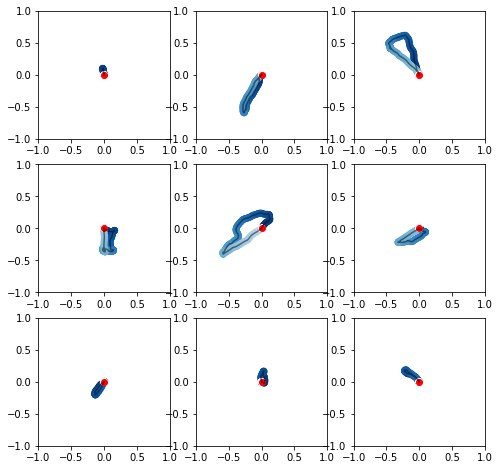

In [9]:
plt.figure(figsize = (8,8))
i = 4

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)


## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [10]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
        

    def forward(self, z):    
        out = self.cnn(z)
        return out


# Idées réductions variabilité fine échelles
# - réduire taille vecteur de bruit : change pas grand chose
# - average pooling + forcer la régularité + upsampling
# - norme L1 fct de cout sur dérivées lon/lat
# - conv poids 1/n (forçage lissage) : ne marche pas dans le générateur(le réseau crée une variabilité + forte aux échelles supérieures)

In [13]:
z = torch.rand((batch_size, 256, 1), device = device)
gen = CNNGenerator().to(device)
gen(z).shape

torch.Size([25, 2, 200])

In [14]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):

        out = self.cnn(x)

        return out.squeeze(1)


In [15]:
dis = CNNDiscriminator().to(device)
dis(x.to(device)).shape

torch.Size([25, 1])

# 50 trajectories

In [16]:
def periodogram(tt):
  periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
  return torch.log(periodogram)

In [17]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
all_traj = traj.copy()
nb_traj = [10, 30, 50]
list_generator = []

for nb in nb_traj:

    tt = all_traj[:nb,:,:]
    batch_size = 5

    ## reduce size dataset
    train_set = TrajDataSet(tt, transform= ToTensor())
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

    generator = CNNGenerator().to(device)
    discriminator = CNNDiscriminator().to(device)

    ### WEIGHT INITIALIZATION
    generator.apply(weights_init)
    discriminator.apply(weights_init)

    criterion = nn.BCELoss()

    lr = 0.0002
    optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))


    # Train the model
    nb_epoch = 5000

    epoch = 0
    for i in progressbar.progressbar(range(nb_epoch)):
        epoch +=1
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch, x in enumerate(train_loader):
            
            #### TRAIN DISCRIMINATOR
            ## true samples
            x = x.to(device)
            batch_size = x.shape[0]

            target_ones = torch.ones((batch_size, 1), device=device)
            target_zeros = torch.zeros((batch_size, 1), device=device)

            discriminator.zero_grad()
            pred_real = discriminator(x)
            loss_real = criterion(pred_real, target_ones)

            ## false samples
            z = torch.randn((batch_size, 256, 1), device=device)
            with torch.no_grad():
                fake_samples = generator(z)
            pred_fake = discriminator(fake_samples)
            loss_fake = criterion(pred_fake, target_zeros)
            
            # combine
            loss = (loss_real + loss_fake) / 2
            loss.backward()
            optim_d.step()

            #### TRAIN GENERATOR
            generator.zero_grad()
            z = torch.randn((batch_size, 256, 1), device=device)

            generated = generator(z)
            classifications = discriminator(generated)
            loss = criterion(classifications, target_ones) +  10*torch.mean((periodogram(generated) - periodogram(x))**2)
            loss.backward()
            optim_g.step()

    list_generator.append(generator)

100% (5000 of 5000) |####################| Elapsed Time: 0:01:23 Time:  0:01:23
100% (5000 of 5000) |####################| Elapsed Time: 0:04:08 Time:  0:04:08
100% (5000 of 5000) |####################| Elapsed Time: 0:06:45 Time:  0:06:45


# Averaged Spatial Distributions

In [19]:
z = torch.randn((100, 256, 1), device=device)

generator_10, generator_30, generator_50 = list_generator[0], list_generator[1], list_generator[2]

traj_sim_50 = generator_50(z).cpu().detach().numpy()
traj_sim_30 = generator_30(z).cpu().detach().numpy()
traj_sim_10 = generator_10(z).cpu().detach().numpy()

In [20]:
import seaborn as sb

Text(0.5, 1.0, 'True Trajectories (n=all)')

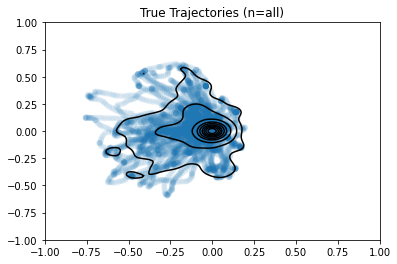

In [25]:
def kde_traj(traj):
  sb.scatterplot(x = traj[:,0,:].flatten(), y = traj[:,1,:].flatten(), edgecolor='none', alpha = 0.1)
  sb.kdeplot(x = traj[:,0,:].flatten(), y = traj[:,1,:].flatten(), gridsize = 100, bw_adjust = 2, color = 'black' ) #, weights = (np.sqrt((traj[:,0,:]**2 + traj[:,1,:]**2)) > 0.01).flatten(), levels=5)
  plt.xlim(-1,1)
  plt.ylim(-1,1)


kde_traj(all_traj)
plt.title('True Trajectories (n=all)')

In [26]:
plt.figure(figsize = (12, 8))

plt.subplot(2,3, 1)
kde_traj(all_traj[:50,:,:])
plt.title('True Trajectories (n=50)')


plt.subplot(2,3, 2)
kde_traj(all_traj[:30,:,:])
plt.title('True Trajectories (n=30)')

plt.subplot(2,3, 3)
kde_traj(all_traj[:10,:,:])
plt.title('True Trajectories (n=10)')

plt.subplot(2,3, 4)
kde_traj(traj_sim_50)
plt.title('Simulated Trajectories (n=50)')


plt.subplot(2,3, 5)
kde_traj(traj_sim_30)
plt.title('Simulated Trajectories (n=30)')

plt.subplot(2,3, 6)
kde_traj(traj_sim_10)
plt.title('Simulated Trajectories (n=10)')

Text(0.5, 1.0, 'Simulated Trajectories (n=10)')

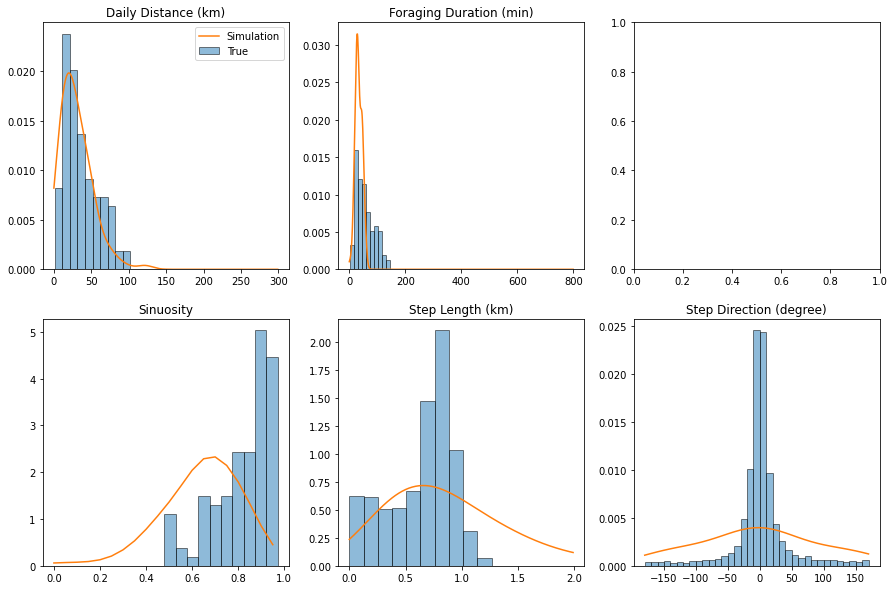

In [24]:
data_fake = format_simulation(traj_sim_50, colony, scale)
data_fake = data_fake[data_fake.dist_colony > 1000]

get_distribution(data, data_fake)
plt.show()
plt.close()

In [23]:
# torch.save(generator, 'basicGAN_cnn_G_SV.pt')
# torch.save(discriminator, 'basicGAN_cnn_D_SV.pt')

# generator = torch.load('basicGAN_cnn_G.pt')
# discriminator = torch.load('basicGAN_cnn_D.pt')